# **ISYARA Project**

## **Import Dependencies**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import shutil
from google.colab import files

## **Preparing Dataset**

__Load Dataset__

In [8]:
df = pd.read_csv('data/ISYARA.csv', index_col = 0)
df.head()

,label,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x16,y16,x17,y17,x18,y18,x19,y19,x20,y20
0,A,0.598521,0.748041,0.549104,0.684306,0.511778,0.576891,0.495771,0.475230,0.489844,...,0.614543,0.590942,0.673632,0.571688,0.670331,0.553751,0.649943,0.606987,0.650445,0.611850
1,A,0.585931,0.743304,0.534998,0.675906,0.494424,0.569049,0.474443,0.470150,0.468428,...,0.599083,0.585985,0.657762,0.566661,0.652262,0.544515,0.634062,0.596524,0.634735,0.605866
2,A,0.582937,0.740494,0.531522,0.674235,0.490327,0.567318,0.470030,0.468717,0.464531,...,0.595469,0.584185,0.653321,0.563287,0.648190,0.541863,0.630493,0.593892,0.630730,0.603513
3,A,0.572295,0.737161,0.519387,0.671176,0.476478,0.562797,0.455147,0.465278,0.449925,...,0.582501,0.580085,0.639611,0.556650,0.634568,0.533522,0.616997,0.585636,0.616099,0.597581
4,A,0.569934,0.739504,0.516317,0.671851,0.472898,0.563042,0.451467,0.465947,0.446541,...,0.579803,0.581296,0.637621,0.558676,0.631795,0.533168,0.614085,0.585640,0.613316,0.599457


**Check Imbalance Data**

In [9]:
df.label.value_counts()

,count
label,
A,500
B,500
X,500
Y,500
W,500
V,500
U,500
T,500
S,500


## **Preprocessing**

### **Ordering Label**

In [10]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

df['label'] = pd.Categorical(df['label'], categories = alphabet, ordered = True)
df = df.sort_values('label').reset_index(drop=True)

In [11]:
X = df.drop(columns = 'label')
y = df['label']

### **One Hot Encoding**

In [12]:
y

,label
0,A
1,A
2,A
3,A
4,A
...,...
12995,Z
12996,Z
12997,Z
12998,Z


In [13]:
y_encoded = pd.get_dummies(y, dtype = float)
y_encoded = np.array(y_encoded)
y_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### __Splitting Data__

**Splitting Data**

**Train : 70%, Validation : 15%, and Test : 15%**

In [14]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y_encoded, test_size = 0.3, random_state = 55, stratify = y)
X_valid, X_test,       y_valid, y_test       = train_test_split(X_test_valid, y_test_valid, test_size = 0.5, random_state = 55, stratify = y_test_valid)

**Check Balanced Splitting**

In [15]:
def check_imbalance_plot(data, ax, title) :
    count_every_category = np.sum(data, axis = 0)

    ax.bar(alphabet, count_every_category)
    ax.set_ylim(0, np.max(count_every_category) + 25)
    ax.set_title(title)

    return ax

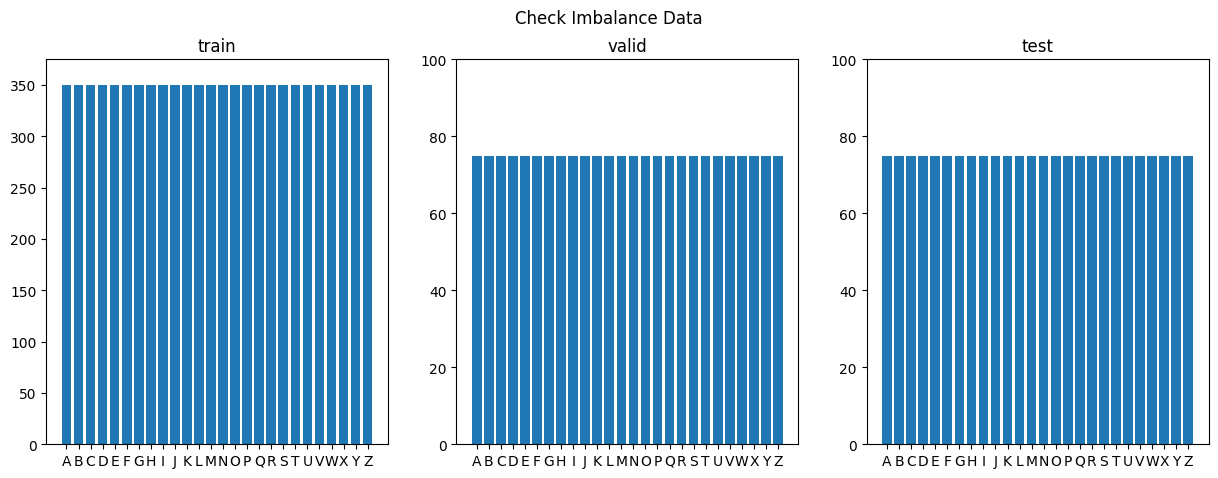

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.suptitle('Check Imbalance Data')

check_imbalance_plot(y_train, ax[0], title = 'train')
check_imbalance_plot(y_valid, ax[1], title = 'valid')
check_imbalance_plot(y_test,  ax[2], title = 'test')

plt.show()

### __Convert DataFrame to Tensor__

In [17]:
def dataframe_to_tensor(X, y) :
    dataset = tf.data.Dataset.from_tensor_slices((X.values, y))
    return dataset

In [18]:
train_dataset = dataframe_to_tensor(X_train, y_train)
valid_dataset = dataframe_to_tensor(X_valid, y_valid)
test_dataset  = dataframe_to_tensor(X_test, y_test)

### __Transformation Data__

In [19]:
def optimized_dataset(dataset, buffersize = tf.data.AUTOTUNE, batch_size = 100) :
    dataset = dataset.cache().prefetch(buffersize).batch(batch_size)
    return dataset

In [20]:
train_dataset = optimized_dataset(train_dataset)
valid_dataset = optimized_dataset(valid_dataset)
test_dataset  = optimized_dataset(test_dataset)

## __Setup Model__

**Build Architecture Model**

In [21]:
model = tf.keras.Sequential([
                                tf.keras.layers.Input(shape = (42,)),
                                tf.keras.layers.Dense(64, activation = 'relu'),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(32, activation = 'relu'),
                                tf.keras.layers.Dense(26, activation = 'softmax')
                                ])

model.compile(loss      = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics   = ['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,690 (22.23 KB)

 Trainable params: 5,690 (22.23 KB)

 Non-trainable params: 0 (0.00 B)

__Build Callbacks Instance__

In [23]:
class IsyaraCallback(tf.keras.callbacks.Callback) :
      def on_epoch_end(self, epoch, logs = None) :
        if logs.get('accuracy') > 0.94 and np.abs(logs.get('val_accuracy') - logs.get('accuracy')) < 0.005 :
          self.model.stop_training = True
          print(' - Model has been stopped')

## **Training Data**

In [ ]:
IR = IsyaraCallback()

history = model.fit(train_dataset, epochs = 1000, validation_data = valid_dataset, callbacks = IR)

Epoch 1/1000
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.0446 - loss: 3.2764 - val_accuracy: 0.1395 - val_loss: 3.1881
Epoch 2/1000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1258 - loss: 3.1613 - val_accuracy: 0.2938 - val_loss: 2.9542
Epoch 3/1000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2323 - loss: 2.8615 - val_accuracy: 0.3487 - val_loss: 2.4096
Epoch 4/1000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3236 - loss: 2.3589 - val_accuracy: 0.5149 - val_loss: 1.9244
Epoch 5/1000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4347 - loss: 1.9370 - val_accuracy: 0.6287 - val_loss: 1.5507
Epoch 6/1000
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5160 - loss: 1.6209 - val_accuracy: 0.7246 - val_loss: 1.2795
Epoch 7/1000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5888 - loss: 1.3847 - val_accuracy: 0.7867 - val_loss: 1.0763
Epoch 8/1000
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6455 - loss: 1.2046 - val_accuracy: 0.

## **Evaluation Model**

**Visualize**

In [ ]:
len(history.history['accuracy']), len(history.history['val_accuracy'])

(87, 87)

In [ ]:
def training_plot(tipe) :
  plt.plot(range(len(history.history[tipe])), history.history[tipe], label = 'train')
  plt.plot(range(len(history.history[tipe])), history.history[f'val_{tipe}'], label = 'valid')

  plt.xlabel('Epoch')
  plt.ylabel(tipe)
  plt.legend()
  plt.title(f'Model {tipe.title()}') ;

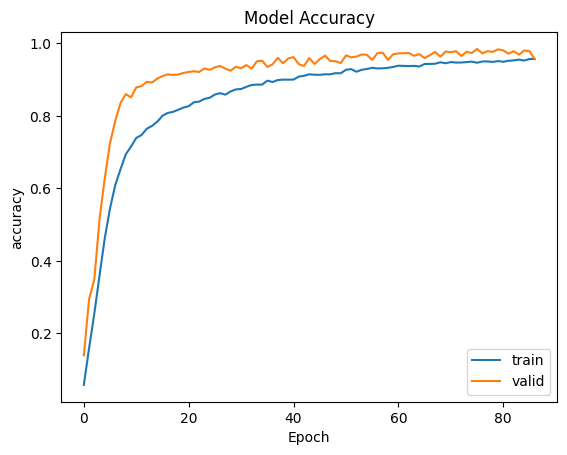

In [ ]:
training_plot('accuracy')

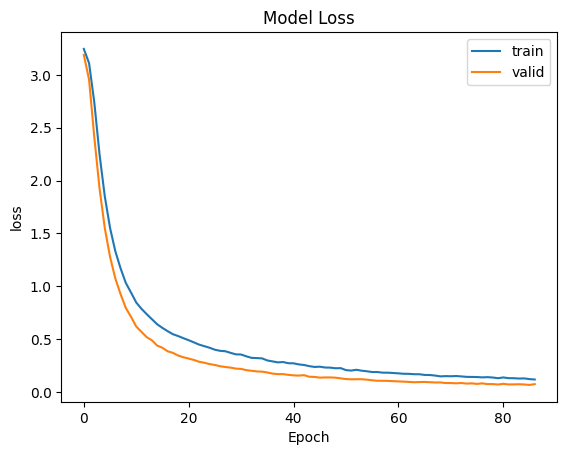

In [ ]:
training_plot('loss')

In [ ]:
train_accuracy = model.evaluate(train_dataset)
valid_accuracy = model.evaluate(valid_dataset)
test_accuracy  = model.evaluate(test_dataset)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9580 - loss: 0.0728
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9602 - loss: 0.0688
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9658 - loss: 0.0667


In [ ]:
accuracy_df = pd.DataFrame(columns = ['loss', 'accuracy'])

accuracy_df.loc['train', :] = train_accuracy
accuracy_df.loc['valid', :] = valid_accuracy
accuracy_df.loc['test',  :] = test_accuracy
accuracy_df

,loss,accuracy
train,0.0715,0.959451
valid,0.075776,0.95641
test,0.070463,0.961026


**Test**

In [ ]:
angka_random = np.random.choice(X_test.index.tolist())

X_random = np.array(df.iloc[angka_random, 1:], dtype = 'float32')
y_random = df.iloc[angka_random, 0]

X_random = tf.expand_dims(X_random, axis = 0)

y_pred = tf.argmax(model.predict(X_random)[0]).numpy()

print('y_random : {}'.format(y_random))
print('y_pred : {}'.format(alphabet[y_pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
y_random : H
y_pred : H


## **Save Model**

In [ ]:
model.save('model/ISYARA.h5')

## **Convert to TFLite**

In [ ]:
model = tf.keras.models.load_model('model/ISYARA.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

converter.optimizations = [tf.lite.Optimize.DEFAULT]

with open('ISYARA.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmphxk2pf7t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  135458480033280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135458541198976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135458467036528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135458467029312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135458468143424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135458478089216: TensorSpec(shape=(), dtype=tf.resource, name=None)
